# Source Extraction and Dark Region identification with good image query
Trying to take our single queried image and put it through SEP to get a segmentation map. Note that SEP has a dependence on numpy but is incompatible with numpy versions 2.0 and later. This code was written on a machine installed with numpy 1.26.4

Primarily from the [SEP documentation](https://sep.readthedocs.io/en/stable/tutorial.html)

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits as fits
from astropy.wcs import WCS
import sep

Single image from legacy survey

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  256 / length of data axis 1                          
NAXIS2  =                  256 / length of data axis 2                          
NAXIS3  =                    4 / length of data axis 3                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
SURVEY  = 'LegacySurvey'                                                        
VERSION = 'DR10    '                                                            
IMAGETYP= 'IMAGE   '           / None                                           
BANDS   = 'griz    '        

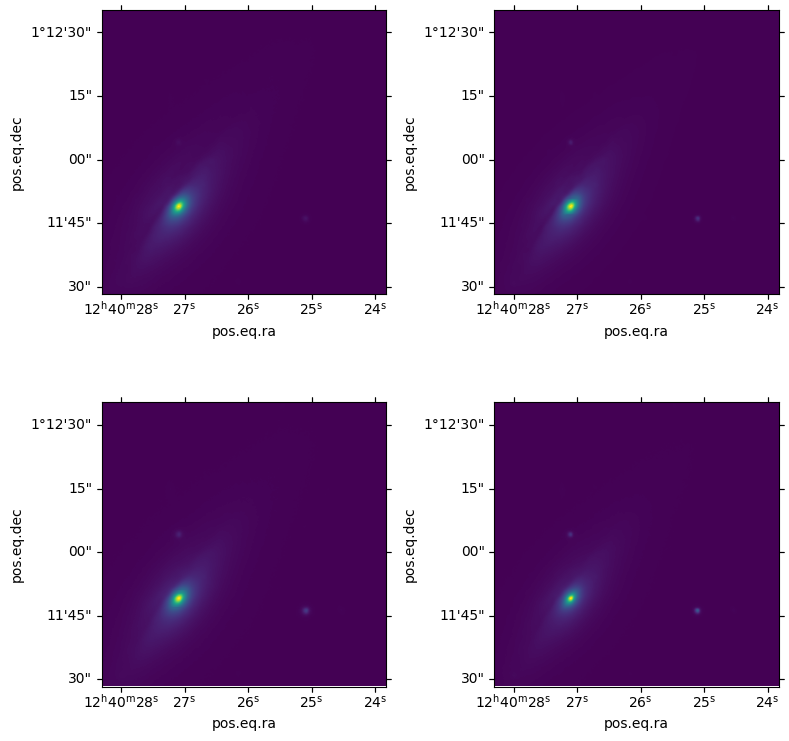

In [45]:
test_image = fits.open("https://web.archive.org/web/20231231120853/https://www.legacysurvey.org/viewer/fits-cutout?ra=190.1086&dec=1.2005&layer=ls-dr10&pixscale=0.262&bands=griz")

# print(repr(test_image[0].header))

imagenum = 2

wcs = WCS(test_image[0].header)

# print(wcs)
wcs = wcs[imagenum, 0:256, 0:256]
zimage = test_image[0].data

fig = plt.figure(figsize=(8,8))
ax = plt.subplot(221, projection=wcs)
ax2 = plt.subplot(222, projection=wcs)
ax3 = plt.subplot(223, projection=wcs)
ax4 = plt.subplot(224, projection=wcs)
lon = ax.coords['ra']
lat = ax.coords['dec']
ax.imshow(zimage[0], norm='linear')
ax2.imshow(zimage[1], norm='linear')
ax3.imshow(zimage[2], norm='linear')
ax4.imshow(zimage[3], norm='linear')

plt.tight_layout()
zimage[0].shape
test_image[0].header

## Thresholding

We want a magnitude limit of $m_{\text{AB},g}\leq21$, so we need to find the corresponding threshold (related to pixel value). For this we need a zero point. The zero point in this particular image is around 27. We are as yet unsure how to convert magnitude limit to pixel threshold in a meaningful way, so we use an arbitrary value.

In [46]:
## Finding the right zero point to know which threshold to use



## Extraction

We assume that the image is already background subtracted, so we are going straight to extracting sources. Running sep.extract gives two arrays - the first is just the image itself, the second is the segmentation map which is an array of the same shape as the image, where each pixel is assigned an integer value. For our purpose, we only need to extract the integers with a value of 0 (dark regions).

In [47]:
im0 = zimage[0].byteswap().newbyteorder()
objects = sep.extract(im0, 1, segmentation_map=True)
seg_map = objects[1]

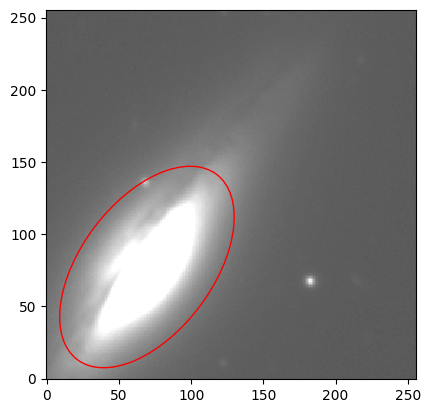

In [48]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(im0), np.std(im0)
im = ax.imshow(im0, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects[0])):
    e = Ellipse(xy=(objects[0]['x'][i], objects[0]['y'][i]),
                width=20*objects[0]['a'][i],
                height=20*objects[0]['b'][i],
                angle=objects[0]['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

Now that we have the data, we extract the segmentation map and rescale it to real sky coords rather than pixels. Every thing in the dr

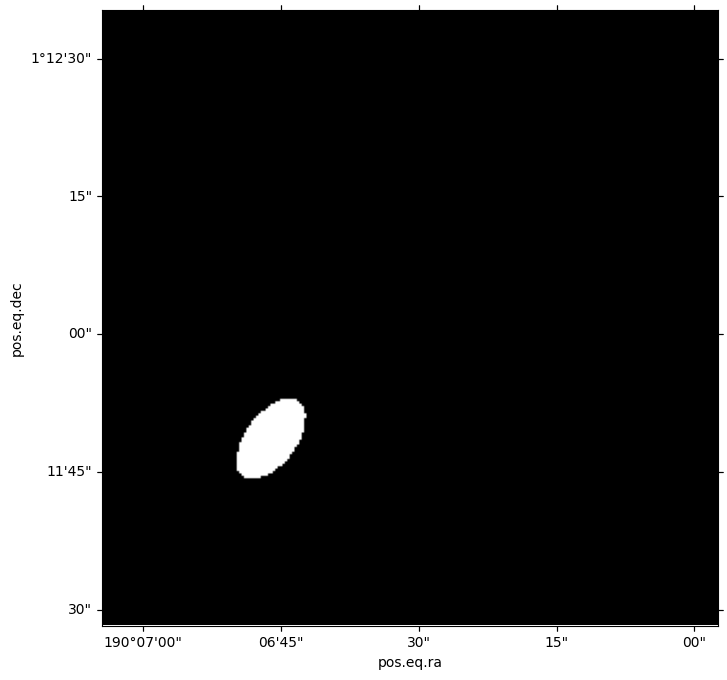

In [49]:
# image coords - pixel scale is uniform for all sources
pixscale = 0.262
ra = test_image[0].header['CRVAL1']
dec = test_image[0].header['CRVAL2']

fig = plt.figure(figsize=(8,8));
ax = fig.add_subplot(111, projection=wcs)
plt.imshow(seg_map, origin='lower', cmap='grey', vmin=0, vmax=1)
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')

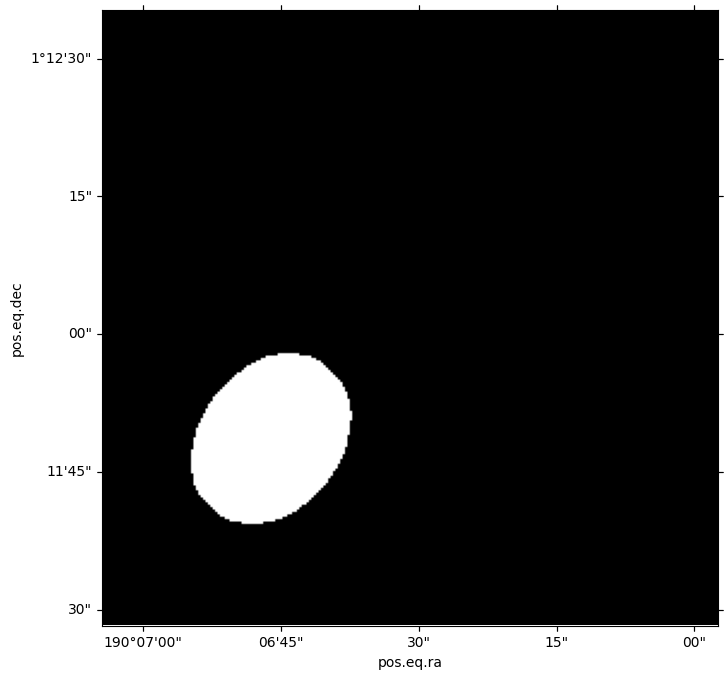

In [50]:
from scipy.ndimage import distance_transform_edt

# Calculate the distance transform of the seg_map
distance = distance_transform_edt(seg_map == 0,sampling=pixscale)

# Expand seg_map for exclusion zones - USING A SMALL EXCL ZONE BC PIC IS SMALL --> CHANGE TO 20 FOR REAL PICS
excl_map = np.copy(seg_map)
excl_map[distance <= 5] = 1

# Plot the updated seg_map
fig = plt.figure(figsize=(8,8));
ax = fig.add_subplot(111, projection=wcs)
plt.imshow(excl_map, origin='lower', cmap='gray', vmin=0, vmax=1)
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
plt.show()



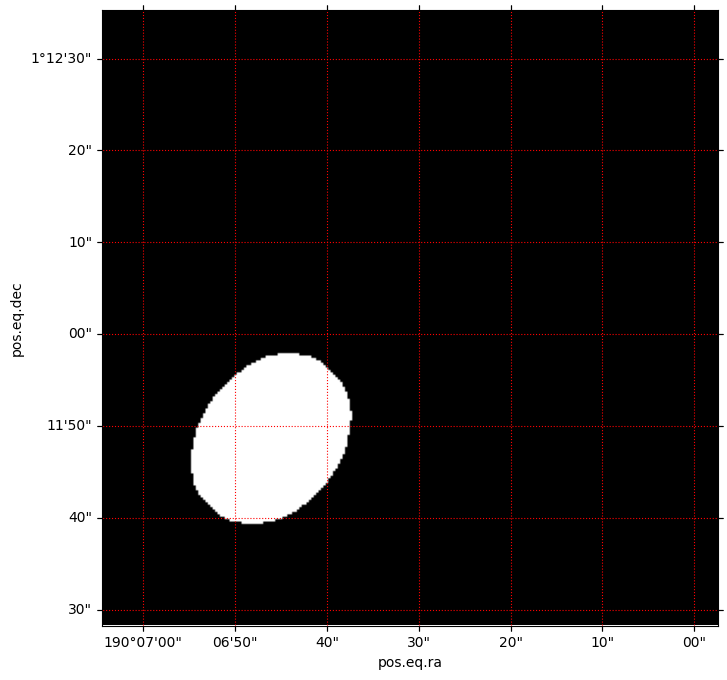

In [51]:
# Applying grid algorithm to the exclusion map
import astropy.units as u

fig = plt.figure(figsize=(8,8));
ax = fig.add_subplot(111, projection=wcs)
plt.imshow(excl_map, origin='lower', cmap='gray', vmin=0, vmax=1)
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
lon.set_ticks(spacing=10*u.arcsec) # CHANGE TO 40 FOR REAL PICS 
lat.set_ticks(spacing=10*u.arcsec)
lon.set_ticklabel(exclude_overlapping=True)
lat.set_ticklabel(exclude_overlapping=True)
ax.coords.grid(True, color='red', ls='dotted')
plt.show()

In [ ]:
dark_ra = []
dark_dec = []

for i in range(len(excl_map)):
    for j in range(len(excl_map[i])):
        if excl_map[i][j] == 0:
            dark_ra.append(j*pixscale + ra)
            dark_dec.append(i*pixscale + dec)

dark_coords = [dark_ra], [dark_dec]

from astropy.coordinates import SkyCoord

c = SkyCoord(dark_ra, dark_dec, unit='deg')
c.to_string('dms')

for a,b in dark_coords:
    if 

['190d06m30.96s 1d12m01.8s',
 '190d22m14.16s 1d12m01.8s',
 '190d37m57.36s 1d12m01.8s',
 '190d53m40.56s 1d12m01.8s',
 '191d09m23.76s 1d12m01.8s',
 '191d25m06.96s 1d12m01.8s',
 '191d40m50.16s 1d12m01.8s',
 '191d56m33.36s 1d12m01.8s',
 '192d12m16.56s 1d12m01.8s',
 '192d27m59.76s 1d12m01.8s',
 '192d43m42.96s 1d12m01.8s',
 '192d59m26.16s 1d12m01.8s',
 '193d15m09.36s 1d12m01.8s',
 '193d30m52.56s 1d12m01.8s',
 '193d46m35.76s 1d12m01.8s',
 '194d02m18.96s 1d12m01.8s',
 '194d18m02.16s 1d12m01.8s',
 '194d33m45.36s 1d12m01.8s',
 '194d49m28.56s 1d12m01.8s',
 '195d05m11.76s 1d12m01.8s',
 '195d20m54.96s 1d12m01.8s',
 '195d36m38.16s 1d12m01.8s',
 '195d52m21.36s 1d12m01.8s',
 '196d08m04.56s 1d12m01.8s',
 '196d23m47.76s 1d12m01.8s',
 '196d39m30.96s 1d12m01.8s',
 '196d55m14.16s 1d12m01.8s',
 '197d10m57.36s 1d12m01.8s',
 '197d26m40.56s 1d12m01.8s',
 '197d42m23.76s 1d12m01.8s',
 '197d58m06.96s 1d12m01.8s',
 '198d13m50.16s 1d12m01.8s',
 '198d29m33.36s 1d12m01.8s',
 '198d45m16.56s 1d12m01.8s',
 '199d00m59.76

In [54]:
grid_size = 40
height, width = excl_map.shape

# Calculate the number of grid squares in x and y directions
num_x_squares = int(width * pixscale / grid_size)
num_y_squares = int(height * pixscale / grid_size)

In [55]:

dark_regions = []

# Iterate through each grid square
for i in range(num_x_squares):
    for j in range(num_y_squares):
        # Calculate the coordinates of the current grid square
        x_start = int(i * grid_size / pixscale)
        x_end = int((i + 1) * grid_size / pixscale)
        y_start = int(j * grid_size / pixscale)
        y_end = int((j + 1) * grid_size / pixscale)
        
        # Check if there is any overlap with the exclusion map
        if np.all(excl_map[y_start:y_end, x_start:x_end] == 0):
            # Calculate the center of the grid square in pixel coordinates
            x_center = (x_start + x_end) / 2
            y_center = (y_start + y_end) / 2
            
            # Convert the center to RA/DEC coordinates
            ra_center, dec_center = wcs.wcs_pix2world(x_center, y_center, 1)
            
            # Append the center coordinates to the list
            dark_regions.append((float(ra_center), float(dec_center)))

dr_transpose = np.asarray(dark_regions).transpose()
dr_transpose

array([], dtype=float64)

IndexError: index 0 is out of bounds for axis 0 with size 0

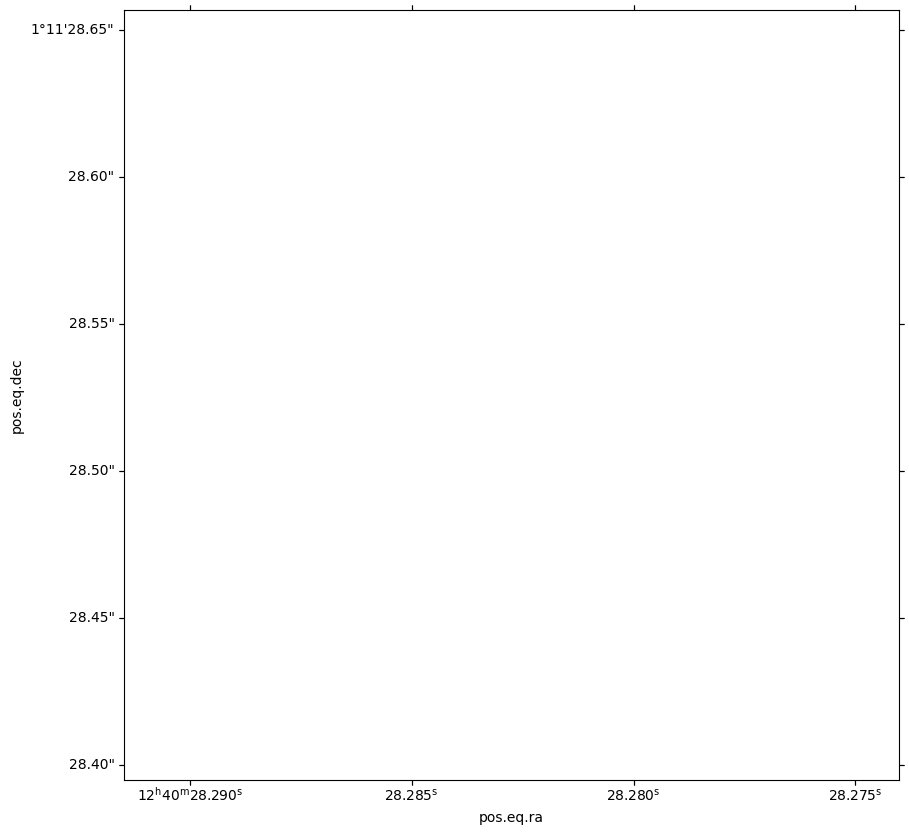

In [56]:
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection=wcs)

plt.plot(dr_transpose[0], dr_transpose[1],'ro', zorder=2)
plt.imshow(excl_map, origin='lower', cmap='grey', vmin=0, vmax=1, zorder=1)


lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
lon.set_ticks(spacing=40*u.arcsec)
lat.set_ticks(spacing=40*u.arcsec)
lon.set_ticklabel(exclude_overlapping=True)
lat.set_ticklabel(exclude_overlapping=True)
ax.coords.grid(True, color='red', ls='dotted')

plt.show()

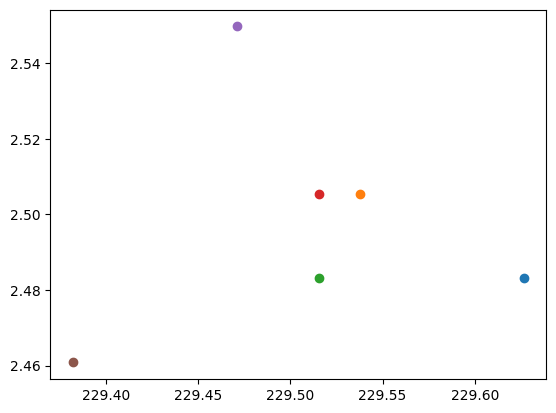

In [35]:
for i in range(len(dark_regions)):
    plt.plot(dark_regions[i][0], dark_regions[i][1],'o', zorder=2)

In [277]:
dark_regions[i][0]

229.3820543447609